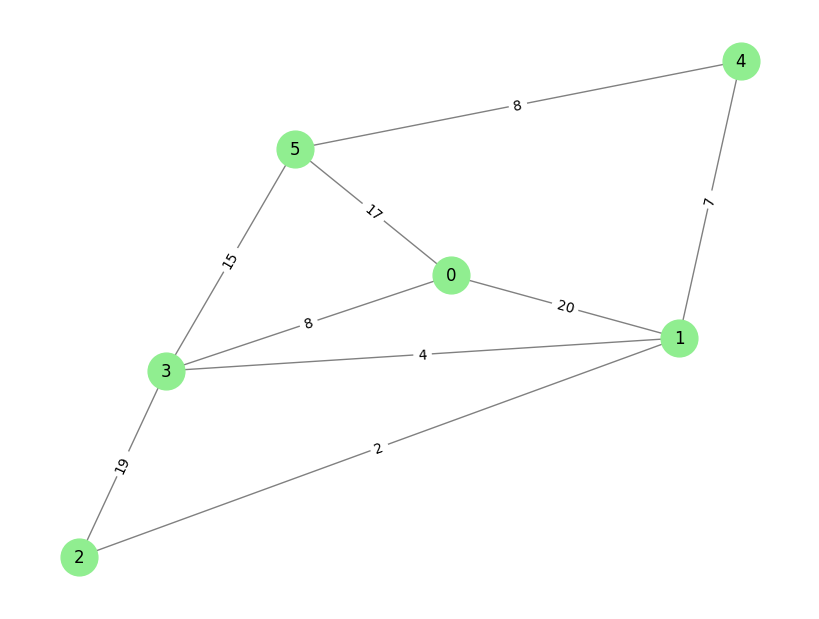

In [181]:
from gurobipy import Model, GRB, quicksum
import random 
import networkx as nx
import matplotlib.pyplot as plt

def generate_random_weighted_graph(num_nodes, edge_prob, weight_range):
    """
    Generate a random undirected weighted graph.
    
    Parameters:
        num_nodes (int): Number of nodes in the graph.
        edge_prob (float): Probability of an edge existing between two nodes.
        weight_range (tuple): Range (min, max) for edge weights.
    
    Returns:
        G (networkx.Graph): A random undirected weighted graph.
    """
    # Create an empty undirected graph
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(num_nodes))

    # Add edges with random weights
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if random.random() < edge_prob:  # Add edge with given probability
                weight = random.randint(*weight_range)  # Random weight in range
                G.add_edge(i, j, weight=weight)
    
    return G


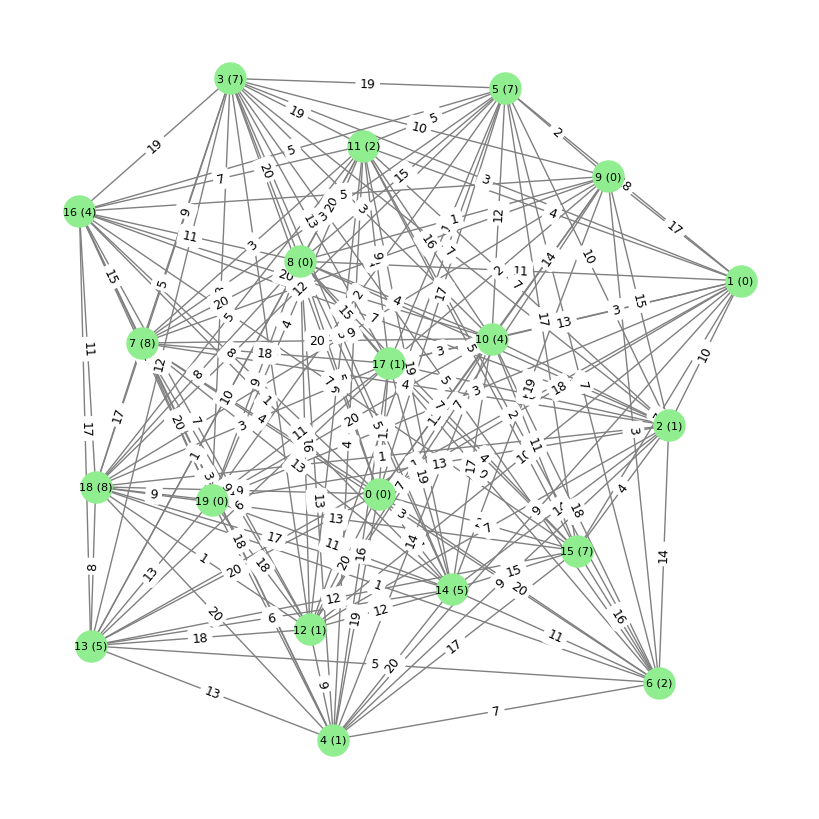

In [339]:
# num_nodes = 6  # Number of nodes
# edge_prob = 0.8  # Probability of edge creation
# weight_range = (1, 20)  # Weight range for edges
# G = generate_random_weighted_graph(num_nodes, edge_prob, weight_range)
# print(G.nodes[2])
def vis_graph(g, edge_colors=None):
    if edge_colors is None:
        edge_colors = "gray"
    pos = nx.spring_layout(G, seed=42)  # Layout for node positioning
    plt.figure(figsize=(8, 8))
    node_labels = {node: f"{data['label']} ({data['prize']})" for node, data in G.nodes(data=True)}

    nx.draw(G, pos, node_size=500, node_color="lightgreen", edge_color=edge_colors)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
    plt.axis("off")
    plt.show()
    
vis_graph(G)

### Traveling Salesman Problem
#### Constraints
- Must visit all nodes
- Minimize the cost of the tour
- Once you have the cycle, you can start from any node

tour: [(0, 5), (3, 4), (1, 0), (2, 1), (4, 2), (5, 3)]
tour: [0, 5, 3, 4, 2, 5]
Total cost: 88.0


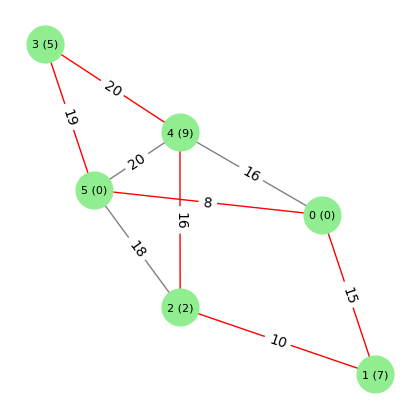

In [231]:
def reconstruct_tour(edges, nodes):
    # Start with node 0
    start = nodes[0]
    tour = [start]
    while len(tour) < len(nodes)-1:
        for i, j in edges:
            if i == tour[-1] and j not in tour:
                tour.append(j)
                break
            elif j == tour[-1] and i not in tour:
                tour.append(i)
                break
    tour.append(nodes[-1])
    return tour

N = list(G.nodes)
E_ = G.edges(data=True)
E = {(i,j) : w['weight'] for (i,j,w) in E_} | {(j,i) : w['weight'] for (i,j,w) in E_}
E_ = E
# print(E_)
for i in N:
    for j in N:
        if i != j and not (i,j) in E:
            E[(i,j)] = 1000
            E[(j,i)] = 1000

# print(N)
N_En = [i for i in range(1,len(N))]
N_Ex = [i for i in range(0,len(N)-1)]
N_Mid = [i for i in range(1, len(N)-1)]

model = Model("TSP")
model.setParam("OutputFlag",0)

x = model.addVars(E.keys(), vtype=GRB.BINARY, name="x")
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
model.setObjective(quicksum(E[i, j] * x[i, j] for i, j in E.keys()), GRB.MINIMIZE)

# Constraints: Every node is entered exactly once
model.addConstrs((quicksum(x[i, j] for j in N if j != i) == 1 for i in N), "Enter")
model.addConstrs((quicksum(x[j, i] for j in N if j != i) == 1 for i in N), "Exit")

# subtour elimination
if len(N_Mid) > 2:
    u = model.addVars(N, vtype=GRB.INTEGER, lb=0, ub=len(N) - 1, name="u")
    for i, j in E.keys():
        if i != 0 and i != 5 and j != 0 and j != 5:
            model.addConstr(u[i] - u[j] + len(N) * x[i, j] <= len(N) - 1)

# Solve the model
model.optimize()
# Print the solution
if model.status == GRB.OPTIMAL:

    solution_edges = [(i, j) for i, j in E.keys() if x[i, j].x > 0.5]
    print("tour:", solution_edges)
    tour =  reconstruct_tour(solution_edges, N)
    print("tour:", tour)
    print("Total cost:", model.objVal)
    
else:
    print("No optimal solution found.")
edge_colors = []
for e in E_.keys():
    if e in solution_edges or (e[1], e[0]) in solution_edges:
        edge_colors.append("red")
    else:
        edge_colors.append("gray")
vis_graph(E_, edge_colors)


### The Orienteering Problem
#### Constraints
- Start from 0, end in 5
- Find a subset of nodes that maximizes the profit at the nodes
- The tour must subject to a maximum travel budget constraint
- Subtour elimination constraint: Assign an index to every interim node in the path. Then the largest difference between any two interim node indeces is the number of interim nodes (if no direct edge). If there is an edge, both sides are equal.

{0: 0, 1: 0, 2: 10, 3: 15, 4: 17, 5: 12, 6: 1, 7: 19, 8: 9, 9: 0}
tour: [0, 4, 3, 5, 9]  tour length:  5
Total reward: 44.0


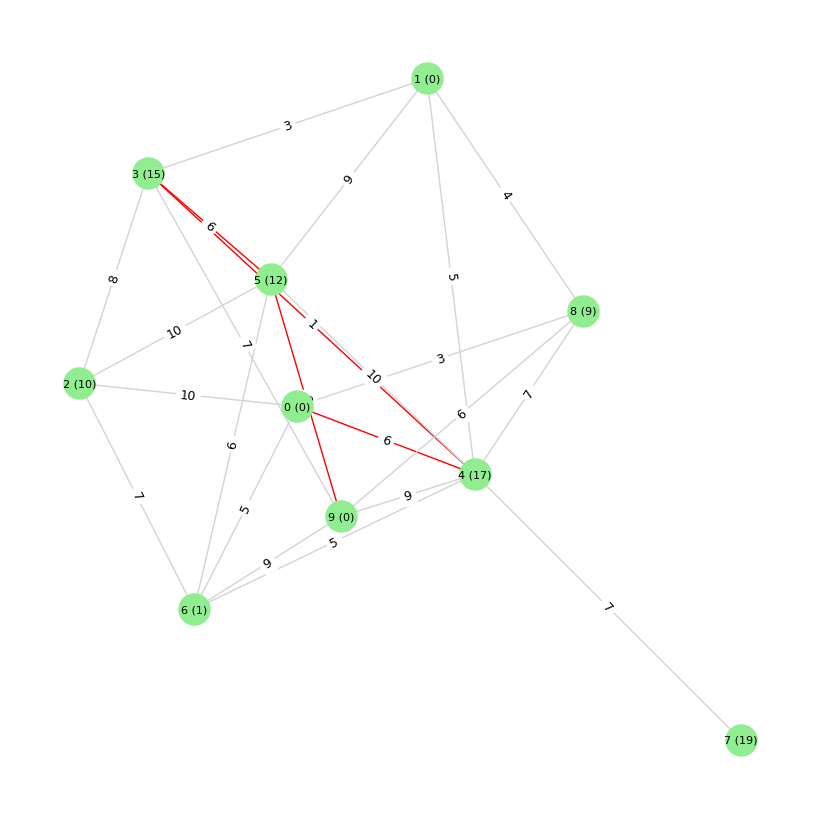

In [595]:
seed = 120
travel_budget = 20

random.seed(seed)
np.random.seed(seed)

num_nodes = 10  # Number of nodes
edge_prob = 0.5  # Probability of edge creation
weight_range = (1, 10)  # Weight range for edges
G = generate_random_weighted_graph(num_nodes, edge_prob, weight_range)
prizes = np.random.randint(20, size=(num_nodes,))
prizes[0] = prizes[-1] = 0
prizes = {n: prizes[n] for n in range(num_nodes)}
labels = {n: f'{n}' for n in range(num_nodes)}
print(prizes)

nx.set_node_attributes(G, prizes, "prize")
nx.set_node_attributes(G, labels, "label")

# vis_graph(G)

N = list(G.nodes)
E_ = G.edges(data=True)
E = {(i,j) : w['weight'] for (i,j,w) in E_} | {(j,i) : w['weight'] for (i,j,w) in E_}

N_En = [i for i in range(1,len(N))]
N_Ex = [i for i in range(0,len(N)-1)]
N_Mid = [i for i in range(1, len(N)-1)]

ps = list(prizes.values())

def reconstruct_tour(edges, nodes):
    start = nodes[0]
    tour = [start]
    while tour[-1] != nodes[-1]:
        for i, j in edges:
            if i == tour[-1] and j not in tour:
                tour.append(j)
                break
            elif j == tour[-1] and i not in tour:
                tour.append(i)
                break
    # tour.append(nodes[-1])
    return tour

model = Model("OP")
model.setParam("OutputFlag",0)

x = model.addVars(E.keys(), vtype=GRB.BINARY, name="x")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
model.setObjective(quicksum(ps[i] * x[i, j] for i in N for j in N if i != j and (i,j) in E), GRB.MAXIMIZE)

# Every node is entered exactly once (flow conservation)
for k in N:
    if k != 0 and k != len(N)-1:  # for intermediate nodes
        model.addConstr(
            quicksum(x[i, k] for i in N if (i, k) in E) == quicksum(x[k, j] for j in N if (k, j) in E), f"flow_conservation_{k}"
        )

# start/end constraints
model.addConstr(quicksum(x[0, j] for j in N if (0, j) in E ) == 1, "start_outgoing")
model.addConstr(quicksum(x[j, 0] for j in N if (j, 0) in E ) == 0, "start_incoming")

model.addConstr(quicksum(x[i, len(N)-1] for i in N if (i, len(N)-1) in E ) == 1, "end_incoming")
model.addConstr(quicksum(x[len(N)-1,i] for i in N if (len(N)-1,i) in E ) == 0, "end_outgoing")

model.addConstr(quicksum(E[i,j] * x[i, j] for i in N for j in N if i != j and (i,j) in E) <= travel_budget, "travel_budget")


# subtour elimination MTZ
u = model.addVars(N_Mid, vtype=GRB.INTEGER, lb=0, ub=len(N) - 1, name="u")
for i in N_Mid:
    for j in N_Mid:
        if (i,j) in E:
            model.addConstr(u[i] - u[j] + len(N_Mid) * x[i, j] <= len(N_Mid) - 1)

model.optimize()

if model.status == GRB.OPTIMAL:
    solution_edges = [(i, j) for i, j in E.keys() if x[i, j].x > 0.5]
    # print("tour:", solution_edges)
    tour =  reconstruct_tour(solution_edges, N)
    print("tour:", tour, " tour length: ", len(tour))
    print("Total reward:", model.objVal)
    edge_colors = []
    for e in E.keys():
        if e in solution_edges or (e[1], e[0]) in solution_edges:
            edge_colors.append("red")
        else:
            edge_colors.append("lightgray")
    vis_graph(E, edge_colors)    
else:
    print("No optimal solution found.")



#### Solving OP with Additive Costs and Rewards
- Convert the OP into an OP with additive costs and solve it
- Compare if there is an equivalent OP for an additive-cost OP (essentially, finding equivalent T_MAX)
    - We do not need to directly establish the equivalency, but that will be interesting to convert an existing OP into this formulation
- Then solve TOP with additive costs

tour: [0, 8, 4, 3, 5, 9]  tour length:  5
Total reward: 30.0


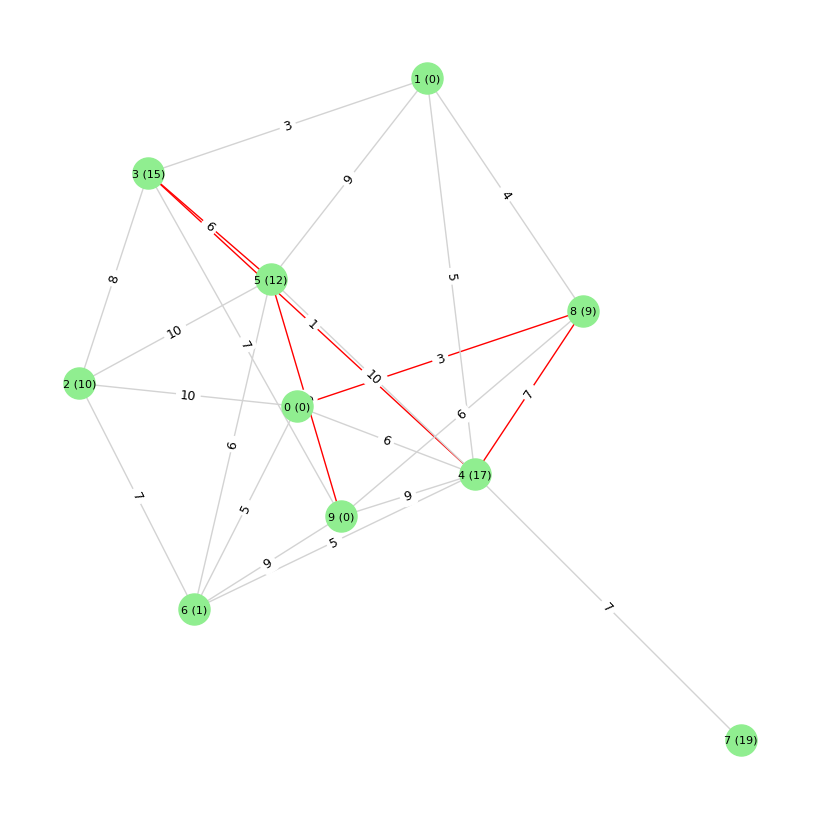

In [552]:
seed = 120
travel_budget = 6

random.seed(seed)
np.random.seed(seed)

num_nodes = 10  # Number of nodes
edge_prob = 0.5  # Probability of edge creation
weight_range = (1, 10)  # Weight range for edges
G = generate_random_weighted_graph(num_nodes, edge_prob, weight_range)
prizes = 1*np.random.randint(20, size=(num_nodes,))
prizes[0] = prizes[-1] = 0
prizes = {n: prizes[n] for n in range(num_nodes)}
labels = {n: f'{n}' for n in range(num_nodes)}

nx.set_node_attributes(G, prizes, "prize")
nx.set_node_attributes(G, labels, "label")
E_ = G.edges(data=True)
N = list(G.nodes)
E = {(i,j) : w['weight'] for (i,j,w) in E_} | {(j,i) : w['weight'] for (i,j,w) in E_}

N_En = [i for i in range(1,len(N))]
N_Ex = [i for i in range(0,len(N)-1)]
N_Mid = [i for i in range(1, len(N)-1)]

ps = list(prizes.values())

def reconstruct_tour(edges, nodes):
    start = nodes[0]
    tour = [start]
    while tour[-1] != nodes[-1]:
        for i, j in edges:
            if i == tour[-1] and j not in tour:
                tour.append(j)
                break
            elif j == tour[-1] and i not in tour:
                tour.append(i)
                break
    return tour

model = Model("ACROP")
model.setParam("OutputFlag",0)

x = model.addVars(E.keys(), vtype=GRB.BINARY, name="x")
model.setObjective(quicksum((ps[i] - E[i,j]) * x[i, j] for i in N for j in N if i != j and (i,j) in E), GRB.MAXIMIZE)

# Every node in the path is entered exactly once (flow conservation)
for k in N:
    if k != 0 and k != len(N)-1:  # for intermediate nodes
        model.addConstr(
            quicksum(x[i, k] for i in N if (i, k) in E) == quicksum(x[k, j] for j in N if (k, j) in E), f"flow_conservation_{k}"
        )

# start/end constraints
model.addConstr(quicksum(x[0, j] for j in N if (0, j) in E ) == 1, "start_outgoing")
model.addConstr(quicksum(x[j, 0] for j in N if (j, 0) in E ) == 0, "start_incoming")

model.addConstr(quicksum(x[i, len(N)-1] for i in N if (i, len(N)-1) in E ) == 1, "end_incoming")
model.addConstr(quicksum(x[len(N)-1,i] for i in N if (len(N)-1,i) in E ) == 0, "end_outgoing")

model.addConstr(quicksum(x[i, j] for i in N for j in N if i != j and (i,j) in E) <= travel_budget, "travel_budget")


# subtour elimination MTZ
u = model.addVars(N_Mid, vtype=GRB.INTEGER, lb=0, ub=len(N) - 1, name="u")
for i in N_Mid:
    for j in N_Mid:
        if (i,j) in E:
            model.addConstr(u[i] - u[j] + len(N_Mid) * x[i, j] <= len(N_Mid) - 1)

model.optimize()

if model.status == GRB.OPTIMAL:
    solution_edges = [(i, j) for i, j in E.keys() if x[i, j].x > 0.5]
    # print("tour:", solution_edges)
    tour =  reconstruct_tour(solution_edges, N)
    print("tour:", tour, " tour length: ", len(tour)-1)
    print("Total reward:", model.objVal)
    edge_colors = []
    for e in E.keys():
        if e in solution_edges or (e[1], e[0]) in solution_edges:
            edge_colors.append("red")
        else:
            edge_colors.append("lightgray")
    vis_graph(E, edge_colors)    
else:
    print("No optimal solution found.")

### Team Orienteering Problem 

#### Constraints



tour: [0, 20, 2, 5, 28, 17, 15, 19, 1, 29]
tour: [0, 4, 6, 26, 9, 11, 24, 29]
tour: [0, 25, 3, 8, 12, 21, 29]
tour: [0, 10, 18, 13, 7, 16, 27, 29]
Total reward: 249.0


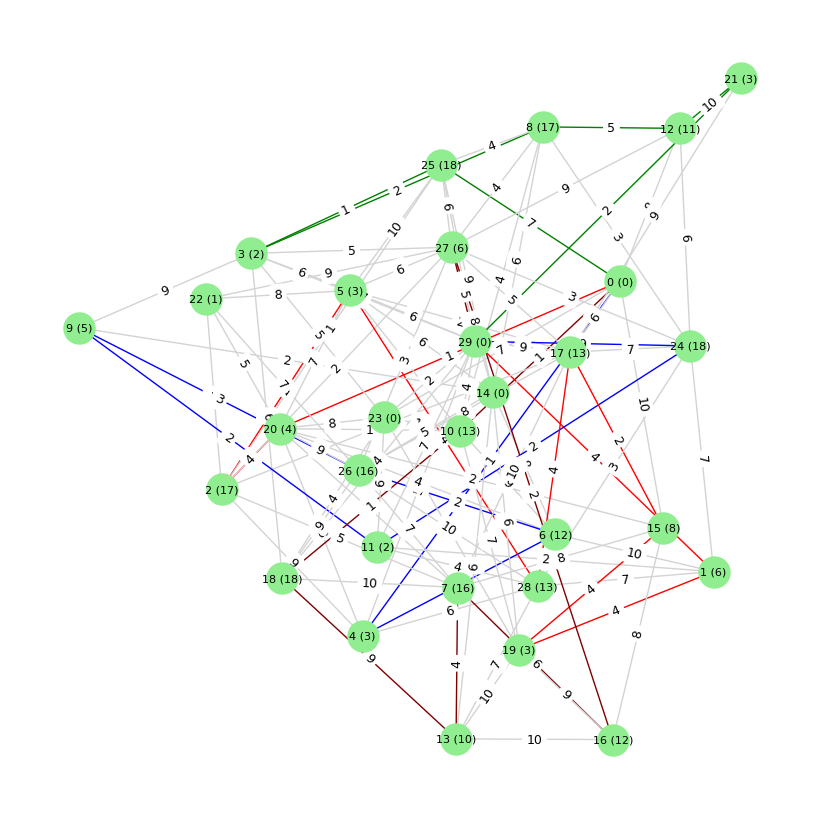

In [656]:
seed = 12
travel_budget = 30

M = 4

random.seed(seed)
np.random.seed(seed)

num_nodes = 30  # Number of nodes
edge_prob = 0.3
# Probability of edge creation
weight_range = (1, 10)  # Weight range for edges
G = generate_random_weighted_graph(num_nodes, edge_prob, weight_range)
prizes = 1*np.random.randint(20, size=(num_nodes,))
prizes[0] = prizes[-1] = 0
prizes = {n: prizes[n] for n in range(num_nodes)}
labels = {n: f'{n}' for n in range(num_nodes)}

nx.set_node_attributes(G, prizes, "prize")
nx.set_node_attributes(G, labels, "label")

N = list(G.nodes)
E_ = G.edges(data=True)
E = {(i,j) : w['weight'] for (i,j,w) in E_} | {(j,i) : w['weight'] for (i,j,w) in E_}

E_keys_players = [(i,j,m) for (i,j) in E.keys() for m in range(M)]

N_En = [i for i in range(1,len(N))]
N_Ex = [i for i in range(0,len(N)-1)]
N_Mid = [i for i in range(1, len(N)-1)]
ps = list(prizes.values())

def reconstruct_tour(edges, nodes):
    start = nodes[0]
    tour = [start]
    while tour[-1] != nodes[-1]:
        for i, j in edges:
            if i == tour[-1] and j not in tour:
                tour.append(j)
                break
            elif j == tour[-1] and i not in tour:
                tour.append(i)
                break
    return tour

model = Model("TOP")
model.setParam("OutputFlag",0)
N_players = [(i,m) for i in N_Mid for m in range(M)]

x = model.addVars(E_keys_players, vtype=GRB.BINARY, name="x")
y = model.addVars(N_players, vtype=GRB.BINARY, name="y")
u = model.addVars(N_players, vtype=GRB.INTEGER, lb=1, ub=len(N) - 1, name="u")

model.setObjective(quicksum((ps[i]) * y[i,m] for i in N_Mid for m in range(M)), GRB.MAXIMIZE)

for k in N_Mid:
    model.addConstr(quicksum(y[k, m] for m in range(M)) <= 1 , "one node one vehicle")

# Every node in the path is entered exactly once (flow conservation)
for m in range(M):
    for k in N_Mid:
        model.addConstr(
            quicksum(x[i, k, m] for i in N_Ex if (i, k) in E)  == quicksum(x[k, j, m] for j in N_En if (k, j) in E), f"visit once by all vehicles or not"
            )
        
for m in range(M):
    for k in N_Mid:
        model.addConstr(
            quicksum(x[i, k, m] for i in N_Ex if (i, k) in E)  == y[k,m], f"visit once by all vehicles or not"
            )

        
for m in range(M):
    model.addConstr(quicksum(x[0, i, m] for i in N if (0, i) in E) == 1, "start outgoing")
    model.addConstr(quicksum(x[i, 0, m] for i in N if (i, 0) in E) == 0, "start incoming")
    
    model.addConstr(quicksum(x[i, len(N)-1, m] for i in N if (i, len(N)-1) in E ) == 1, "end incoming")
    model.addConstr(quicksum(x[len(N)-1, i, m] for i in N if (len(N)-1, i) in E ) == 0, "end outgoing")

for m in range(M):    
    model.addConstr(quicksum(x[i, j, m]*E[i, j] for i in N for j in N if i != j and (i,j) in E) <= travel_budget, "travel_budget")
    

for m in range(M):
    for i in N_Mid:
        for j in N_Mid:
            if (i,j) in E:
                model.addConstr(u[i,m] - u[j,m] + 1 <= (len(N) - 1)*(1 - x[i, j, m]))

model.optimize()
# print(M)
if model.status == GRB.OPTIMAL:
    solution = {}
    for m in range(M):
        solution_edges = [(i, j) for i, j in E.keys() if x[i, j, m].x > 0.5]
        solution[m] = solution_edges
        tour =  reconstruct_tour(solution_edges, N)
        print("tour:", tour)

    # print("tour:", tour, " tour length: ", len(tour)-1)
    print("Total reward:", model.objVal)
    edge_colors = ['lightgray' for i in range(len(E.keys()))]
    colors = ['red', 'blue','green', 'maroon']
    e_i = 0
    for e in E.keys():
        for m in range(M):
            if e in solution[m] or (e[1], e[0]) in solution[m]:
                edge_colors[e_i] = colors[m]
        e_i += 1
            
    vis_graph(E, edge_colors)    
else:
    print("No optimal solution found.")

In [612]:
subsets = list(chain.from_iterable(combinations(N_Mid, r) for r in range(len(N_Mid) + 1)))
print(subsets)


[(), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 5), (4, 6), (4, 7), (4, 8), (5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (7, 8), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 2, 6), (1, 2, 7), (1, 2, 8), (1, 3, 4), (1, 3, 5), (1, 3, 6), (1, 3, 7), (1, 3, 8), (1, 4, 5), (1, 4, 6), (1, 4, 7), (1, 4, 8), (1, 5, 6), (1, 5, 7), (1, 5, 8), (1, 6, 7), (1, 6, 8), (1, 7, 8), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 3, 7), (2, 3, 8), (2, 4, 5), (2, 4, 6), (2, 4, 7), (2, 4, 8), (2, 5, 6), (2, 5, 7), (2, 5, 8), (2, 6, 7), (2, 6, 8), (2, 7, 8), (3, 4, 5), (3, 4, 6), (3, 4, 7), (3, 4, 8), (3, 5, 6), (3, 5, 7), (3, 5, 8), (3, 6, 7), (3, 6, 8), (3, 7, 8), (4, 5, 6), (4, 5, 7), (4, 5, 8), (4, 6, 7), (4, 6, 8), (4, 7, 8), (5, 6, 7), (5, 6, 8), (5, 7, 8), (6, 7, 8), (1, 2, 3, 4), (1, 2, 3, 5), (1, 2, 3, 6), (1, 2, 3, 7), (1, 2, 3, 8), (1, 2, 4, 5), (1, 2, 4, 6), (1, 2, 4,

In [609]:
print(u)
for k in u:
    # if u[1,i].X > 0.5:
        print(k, u[k].X)

{(0, 1): <gurobi.Var u[0,1] (value -0.0)>, (1, 1): <gurobi.Var u[1,1] (value -0.0)>, (0, 2): <gurobi.Var u[0,2] (value 1.0)>, (1, 2): <gurobi.Var u[1,2] (value -0.0)>, (0, 3): <gurobi.Var u[0,3] (value -0.0)>, (1, 3): <gurobi.Var u[1,3] (value 1.0)>, (0, 4): <gurobi.Var u[0,4] (value 1.0)>, (1, 4): <gurobi.Var u[1,4] (value -0.0)>, (0, 5): <gurobi.Var u[0,5] (value -0.0)>, (1, 5): <gurobi.Var u[1,5] (value 1.0)>, (0, 6): <gurobi.Var u[0,6] (value -0.0)>, (1, 6): <gurobi.Var u[1,6] (value -0.0)>, (0, 7): <gurobi.Var u[0,7] (value 0.0)>, (1, 7): <gurobi.Var u[1,7] (value 0.0)>, (0, 8): <gurobi.Var u[0,8] (value 0.0)>, (1, 8): <gurobi.Var u[1,8] (value -0.0)>}
(0, 1) -0.0
(1, 1) -0.0
(0, 2) 1.0
(1, 2) -0.0
(0, 3) -0.0
(1, 3) 1.0
(0, 4) 1.0
(1, 4) -0.0
(0, 5) -0.0
(1, 5) 1.0
(0, 6) -0.0
(1, 6) -0.0
(0, 7) 0.0
(1, 7) 0.0
(0, 8) 0.0
(1, 8) -0.0
